# eCommerce analytics

## Algorithmic Methods of Data Mining (Sc.M. in Data Science), Fall 2020

**Goal:** 
answer some research questions (RQs) that may help to discover and interpret meaningful patterns in data and eventually increase the number of sales

## Imports

In [1]:
# It's sufficient to use basic libraries such as pandas and matplotlib for the EDA 
# !pip3 install pandas numpy matplotlib seaborn 
import os
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
## In case we prefer dash to pandas we should install it using the following commands:
# !python3 -m pip install "dask[complete]" --upgrade
# !python3 -m pip install "dask[array]" --upgrade
# !python3 -m pip install "dask[bag]" --upgrade
# !python3 -m pip install "dask[dataframe]" --upgrade
# !python3 -m pip install "dask[delayed]" --upgrade
# !python3 -m pip install "dask[distributed]" --upgrade
# import dask.dataframe as dd  
## Now we can call similar functions we would use in pandas but in memory efficient way

## Data retrival

Input data consists of one *.csv file (dataset) per months, for example

- 2019-Oct.csv for data collected in October 2019
- 2019-Nov.csv for data collected in November 2019

Each dataset is too big to be processed directly, there are a couple of approaches that can be applied to perform the analysis:

1. running a **bash script** so extract partial information which is essential to reply on a particular RQ, for example:

    for exploring number of purchases per category we may write a script ('*generate_subset_with_n_purchases_per_category.sh*') which
     - creates a subset that contains only rows with event_type="purchase"
     - finds all unique categories present in the subset
     - loops through categories and for each category calculates number of lines present in the subset

    We started with that approach but it required different scripts for each single sub question of any RQ, it was time consuming and limited the vision of the whole picture


2. randomly **subsampling** dataset and perform analysis on smaller version
    
    can be implemented with pd.read_csv(..., **skiprows**=lambda x: ...)

    if we manage to extract data which represent the whole dataset well we may concentrate on the analysis of that cutted version of the dataset to make estimations
    
    the disadvantage of such an approach is that we can not make accurate evaluation and it's challenging to subsample the dataset to inherit at least the same statistical characteristics of the initial dataset in case we need to extrapolate the data to evaluate absolute values
 
3. splitting a file into **chunks** which allows to work with a dataset without overloading RAM
    
    In this case we don't need a powerful machine to run the code and we don't loose information by subsampling the dataset itself.
    
    There are two easy ways to work with chunks for a dataframe
    
    * by using **dash** library
    * by using **pandas** and modying default parameters for pd.read_csv()
    
    We chose to proceed by using pandas
    
As can be seen https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html there are a couple of parameters changing of which allows us to speed the operation up and also set up chunksize

* **usecols**: we specify only columns that are needed for a RQ
* **dtype**: we specify the format of data in each column to choose the min suffucient type representation 
* **engine**: C parser engine is obviously faster so we stick to it
* **na_filter**: if we switch off extra empty values handling it increases the performance
* **memory_map**: setting it to True removes I/O overhead as file object is directly mapped onto memory
* **chunksize**: sets chunk size of an iterable object
* **nrows**: while testing the code we may limit number of rows we consider 


In [2]:
# Datasets to be analyzed
df_labels = ['2019-Oct', '2019-Nov']

In [3]:
# Set up defaults that are to be used by functions corresponsing to different RQs
default_nrows = 100_000
deafult_size_mb = 2  # 500
default_file_label = df_labels[0]
default_aws = False

In [4]:
dataset_info = {
    '2019-Oct': {
        'total_n_rows': 42_448_764,
        'total_size_mb': 5407
    },
    '2019-Nov': {
        'total_n_rows': 67_501_979,
        'total_size_mb': 8590
    },
}

def get_chunksize(df_label=default_file_label, size_mb=deafult_size_mb):
    """
    Function to calculate chunk size based on memory we're ready to allocate while processing the file
    """
    if size_mb is not None:
        total_size_mb = dataset_info.get(df_label, dict()).get('total_size_mb', 7000)
        n_chunks = max(1, np.ceil(total_size_mb / size_mb))
        total_n_rows = dataset_info.get(df_label, dict()).get('total_n_rows', None)
        if total_n_rows:
            return int(np.ceil(total_n_rows / n_chunks))
    return None

In [5]:
def get_file_path(df_label=default_file_label, aws=False):
    """
    Function to retrive by a label either *.csv path of a file stored locally 
    or request downloading from a file located on AWS S3
    """
    if aws:
        return f"s3://sapienza2020adm/ecommerce/{df_label}.csv"
    return f"datasets/{df_label}.csv"

In [6]:
def read_csv(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows,
    usecols: list = None, 
    dtype: dict = None, 
    parse_dates: list = False,
    date_parser=None
):
    """
    Key function to retrive data (in chunks by default)
    """
    return pd.read_csv(
        get_file_path(df_label=df_label, aws=aws),
        usecols=usecols,
        dtype=dtype,
        engine='c',
        na_filter=False,
        memory_map=True,
        chunksize=get_chunksize(df_label=df_label, size_mb=size_mb),
        nrows=nrows,
        parse_dates=parse_dates,
        date_parser=date_parser
    )

In [7]:
# Display some rows to see the dataset structure
local_n_rows = 5
october_df = read_csv(
    df_label=default_file_label,
    parse_dates=['event_time'],
    date_parser=pd.to_datetime,
    size_mb=None,  # without chunks
    nrows=local_n_rows
)
october_df.head(local_n_rows)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [8]:
def get_unique_events_types(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows,
):
    # Take only needed columns such as 'event_type'
    reader = read_csv(
        df_label=df_label, 
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['event_type'],
        dtype={'event_type': str}
    )
    events_types = list()
    for chunk in reader:
        print(".", end="")
        events_types += list(chunk['event_type'].unique())
    print(
        f"\n{df_label + ' | ' if df_label else ''}got the following options as an event_type: "
        f"{list(set(events_types))}"
    )

In [11]:
for df_label in df_labels:
    get_unique_events_types(df_label=df_label, nrows=None)  # perform for the whole DS

...........
2019-Oct | got the following options as an event_type: ['view', 'cart', 'purchase']
..................
2019-Nov | got the following options as an event_type: ['view', 'cart', 'purchase']


### First observations

1. As can be seen we have some **missing values** for category_code and brand. We may need to fill them in case we have other rows for the same category_id or drop them to exclude them from the analysis if there is not match found

2. There are solely 3 event_type categories, there is no information about an event such as 'removed from a cart'

# RQ1

A marketing **funnel** describes your customer’s journey with your e-commerce. 

It may involve different stages, beginning when someone learns about your business, when he/she visits your website for the first time, to the purchasing stage, marketing funnels map routes to conversion and beyond.

Suppose your funnel involves just three simple steps: 

1) view, 
2) cart, 
3) purchase. 


- **Which is the rate of complete funnels**?


- **What’s the operation users repeat more on average within a session?** Produce a plot that shows the average number of times users perform each operation (view/removefromchart etc etc).


- **How many times, on average, a user views a product before adding it to the cart?**


- **What’s the probability that products added once to the cart are effectively bought?**


- **What’s the average time an item stays in the cart before being removed?**


- **How much time passes on average between the first view time and a purchase/addition to cart?**

## Which is the rate of complete funnels? 

Theoretically if user viewed a product put in into the cart another day and purchased some other day the funnel is still complete. Session is changed every time a user come back to the store after a long pause, this column can be used for grouping.

There are "inconsistent" funnels in the dataset where after viewing a product person can buy it without putting into a cart -> **complete** funnels are the ones that lead to a **purchase**.

In [9]:
def get_complete_funnels_rate(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows
):
    # Take only needed columns such as 'user_session', 'product_id', 'event_time'
    # product_id: np.uint16 ~ [0, 4294967295] | could take less space if would have been normalized
    # dataset have been already sorted by event_time, we can skip uploading that column
    reader = read_csv(
        df_label=df_label, 
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['user_session', 'product_id', 'event_type'],
        dtype={'user_session': str, 'product_id': np.uint32, 'event_type': str}
    )
    events_handler = pd.DataFrame()
    for chunk in reader:
        print(".", end="")
        # group by and count events of both types 'view' and 'purchase'
        events_operations = chunk[chunk['event_type'].isin(['view', 'purchase'])].groupby(
            ['user_session', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
    events_handler = events_handler.reset_index()
    # sum up and divide
    complete_funnel = sum(events_handler['event_type'] == 'purchase')
    product_user_pairs = sum(events_handler['event_type'] == 'view')
    print(
        f"\n{df_label + ' | ' if df_label else ''}Complete funnels: "
        f"{complete_funnel} out of {product_user_pairs}"
    )
    rate = int(round(complete_funnel / product_user_pairs, 2) * 100) if product_user_pairs > 0 else 0
    print(f"{df_label + ' | ' if df_label else ''}Rate of complete funnels: {rate}%")

In [10]:
for df_label in df_labels:
    get_complete_funnels_rate(df_label=df_label)

.......
2019-Oct | Complete funnels: 1549 out of 67767
2019-Oct | Rate of complete funnels: 2%
.......
2019-Nov | Complete funnels: 1352 out of 66169
2019-Nov | Rate of complete funnels: 2%


## What’s the operation users repeat more on average within a session? 
Produce a plot that shows the average number of times users perform each operation (view/etc).

In [15]:
def most_repeated_operation(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['user_session', 'event_type'],
        dtype={'user_session': str, 'event_type': str}
    )
    sessions_handler = pd.DataFrame()
    for chunk in reader:
        print(".", end="")
        # group by session and event type, count events for each event type
        session_operations = chunk.groupby(
            ['user_session', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        # important to fill with 0 absent events
        session_operations = session_operations.reindex(
            pd.MultiIndex.from_product(
                [session_operations.index.levels[0], ['view', 'cart', 'purchase']], 
                names=['user_session', 'event_type']
            ),
            fill_value=0
        )
        if sessions_handler.empty:
            sessions_handler = session_operations
        else:
            sessions_handler = sessions_handler.add(session_operations, fill_value=0).astype(np.uint32)
    sessions_handler = sessions_handler.reset_index()
    # Average number of times users perform each operation (within a session)
    session_operations_avg = sessions_handler.groupby(
        ['event_type']
    ).n_events.mean().to_frame().reset_index().sort_values(by=['n_events'], ascending=False)
    plot = sns.barplot(data=session_operations_avg, x="event_type", y="n_events")
    for p in plot.patches:
        plot.annotate(
            format(p.get_height(), ',.3f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center', 
            xytext = (0, 10), 
            textcoords = 'offset points'
        )

    plt.title(f"\n{df_label + ' | ' if df_label else ''}Number of events by type")
    plt.xlabel('')
    plt.ylabel('Number of events')
    plt.ylim(0, session_operations_avg['n_events'].max() * 1.1)
    plt.show()

.......

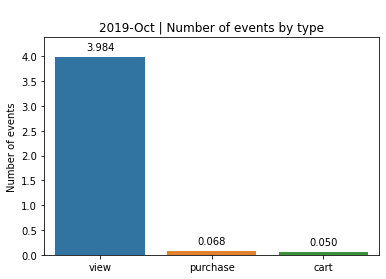

.......

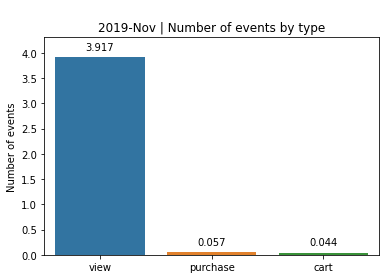

In [14]:
for df_label in df_labels:
    most_repeated_operation(df_label=df_label)

## How many times, on average, a user views a product before adding it to the cart?

In [16]:
def get_avg_n_of_views_for_view_cart_funnels(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['user_session', 'product_id', 'event_type'],
        dtype={'user_session': str, 'product_id': np.uint32, 'event_type': str}
    )
    events_handler = pd.DataFrame()
    for chunk in reader:
        print(".", end="")
        # group by user, product and event type, count events
        events_operations = chunk[chunk['event_type'].isin(['view', 'cart'])].groupby(
            ['user_session', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
    # unstack event_type
    events_handler = events_handler.unstack(level=-1)
    events_handler.columns = events_handler.columns.droplevel()
    # drop user-product pairs where product has not been added to a cart
    events_handler = events_handler.dropna(subset=['cart'])
    # fill missing view with 0
    events_handler = events_handler.fillna(0).astype(np.uint32)
    # calculate number of views per cart event for user-product pair and find mean
    avg_n_times_viewed_before_cart = (events_handler.view / events_handler.cart).mean()
    print(
        f"\n{df_label + ' | ' if df_label else ''}"
        f"A user views a product before adding it to the cart in average "
        f"{round(avg_n_times_viewed_before_cart, 3)} times"
    )

In [17]:
for df_label in df_labels:
    get_avg_n_of_views_for_view_cart_funnels(df_label=df_label)

.......
2019-Oct | A user views a product before adding it to the cart in average 1.984 times
.......
2019-Nov | A user views a product before adding it to the cart in average 2.062 times


## What’s the probability that products added once to the cart are effectively bought?

In [18]:
def get_probability_that_if_in_cart_product_is_bought(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['user_session', 'product_id', 'event_type'],
        dtype={'user_session': str, 'product_id': np.uint32, 'event_type': str}
    )
    events_handler = pd.DataFrame()
    for chunk in reader:
        print(".", end="")
        events_operations = chunk[chunk['event_type'].isin(['purchase', 'cart'])].groupby(
            ['user_session', 'product_id', 'event_type']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_events'}
        )
        if events_handler.empty:
            events_handler = events_operations
        else:
            events_handler = events_handler.add(events_operations, fill_value=0).astype(np.uint32)
    # unstack event_type column
    events_handler = events_handler.unstack(level=-1)
    events_handler.columns = events_handler.columns.droplevel()
    # drop user-product pairs where product has not been added to a cart
    events_handler = events_handler.dropna(subset=['cart'])
    # fill missing purchases with 0
    events_handler = events_handler.fillna(0).astype(np.uint32)
    # calculate number of purchases per cart event for user-product pair and find mean
    prob_if_in_cart_bought = (events_handler.purchase / events_handler.cart).mean()
    print(
        f"\n{df_label + ' | ' if df_label else ''}"
        f"The probability that products added once to the cart are effectively bought "
        f"{round(prob_if_in_cart_bought * 100)}%"
    )

In [19]:
for df_label in df_labels:
    get_probability_that_if_in_cart_product_is_bought(df_label=df_label)

.......
2019-Oct | The probability that products added once to the cart are effectively bought 48%
.......
2019-Nov | The probability that products added once to the cart are effectively bought 46%


## What’s the average time an item stays in the cart before being removed?

As we're missing the information about the remove-from-cart events we'll calculate the average time an item stays in the cart before being purchased (which is also removing the item from the cart)


In [100]:
def get_avg_time_from_cart_to_purchase(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    size_mb: float = deafult_size_mb,
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        size_mb=size_mb,
        nrows=nrows,
        usecols=['event_time', 'event_type', 'product_id', 'user_session'],
        dtype={'user_session': str, 'product_id': np.uint32, 'event_type': str, 'event_time': str}
    )
    time_from_cart_to_purchase_list = list()
    for chunk in reader:
        print(".", end="")
        # filter only 'purchase' and 'view' events (in case we'd have 'remove' type we could consider it)
        chunk = chunk[chunk['event_type'].isin(['purchase', 'cart'])]
        # drop timezone
        chunk['event_time']=pd.to_datetime(chunk['event_time']).dt.tz_convert(None)
        # add fake key in case of duplicates (several purchases/cart events per session)
        chunk['key'] = chunk.groupby(["user_session", "product_id", "event_type"]).cumcount()
        #  create pivot table
        chunk = chunk.pivot_table(
            index=["user_session", "product_id", "key"], 
            columns=["event_type"], 
            values=["event_time"], 
            aggfunc='max'
        )
        chunk.columns = chunk.columns.droplevel()
        # convert time difference into seconds
        chunk['delta'] = (chunk.purchase - chunk.cart).dt.seconds
        # keep only rows where we actually can calculate the difference
        chunk = chunk.dropna()
        # record all delta
        chunk['delta'] = chunk['delta'].astype(int).apply(lambda x: [x])
        chunk = chunk.drop(columns=['cart', 'purchase']).groupby(
            ['user_session', 'product_id']
        ).delta.sum().to_list()  # sum appends to array
        chunk = itertools.chain.from_iterable(chunk)
        time_from_cart_to_purchase_list.extend(chunk)
    # calculate mean of all delta
    avg_time_from_cart_to_purchase = np.array(time_from_cart_to_purchase_list).mean()
    print(
        f"\n{df_label + ' | ' if df_label else ''}"
        f"The average time an item stays in the cart before being purchased "
        f"{pd.to_timedelta(avg_time_from_cart_to_purchase, unit='s')}"
    )

In [101]:
for df_label in df_labels:
    get_avg_time_from_cart_to_purchase(df_label=df_label)

.......
2019-Oct | The average time an item stays in the cart before being purchased 0 days 01:34:35.236607143
.......
2019-Nov | The average time an item stays in the cart before being purchased 0 days 00:27:44.678756477


## How much time passes on average between the first view time and a purchase/addition to cart?

In [159]:
# Display some rows to see the dataset structure
local_n_rows = 5
october_df = read_csv(
    df_label=default_file_label,
    parse_dates=['event_time'],
    date_parser=pd.to_datetime,
    size_mb=None,  # without chunks
    nrows=local_n_rows
)
october_df.head(local_n_rows)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [114]:
chunk = read_csv(
    nrows=100_000,
    size_mb=None,  # without chunks
    usecols=['event_time', 'event_type', 'product_id', 'user_session'],
    dtype={'user_session': str, 'product_id': np.uint32, 'event_type': str, 'event_time': str}
)
chunk['event_time']=pd.to_datetime(chunk['event_time']).dt.tz_convert(None)  # for datetime conversion
# daily_summary_table = dataset.groupby(  # can be used for the conversion, handy
#     by=[dataset['event_time'].dt.normalize()]
# ).agg(
#     n_daily_visits=('user_session', lambda x: x.nunique())
# )
# replace events which are not 'view' with new category goal
chunk.loc[:, 'event_type'] = chunk['event_type'].map({'purchase': 1, 'cart': 1, 'view': 0})
chunk = chunk.set_index(['user_session', 'product_id'])
chunk = chunk.dropna()
# chunk = chunk.event_type.where(chunk['event_type'].isin(['purchase', 'cart']), 1, 0)
# chunk['key'] = chunk.groupby(["user_session", "product_id", "event_type"]).cumcount()
# chunk = chunk.set_index(['user_session', 'product_id'])
# chunk = chunk.pivot_table(
#     index=["user_session", "product_id"], 
#     columns=["event_type"], 
#     values=["event_time"], 
#     aggfunc='min'
# )
# chunk.fillna()
# chunk.columns = chunk.columns.droplevel()
# chunk = chunk.dropna()
# chunk['delta'] = (chunk.purchase - chunk.cart).dt.seconds
# chunk = chunk.drop(columns=['cart', 'purchase']).groupby(
#     ['user_session', 'product_id']
# ).delta.agg('mean').to_frame()
chunk.head(30)

,,event_time,event_type
user_session,product_id,,
72d76fde-8bb3-4e00-8c23-a032dfed738c,44600062,2019-10-01 00:00:00,0
9333dfbd-b87a-4708-9857-6336556b0fcc,3900821,2019-10-01 00:00:00,0
566511c2-e2e3-422b-b695-cf8e6e792ca8,17200506,2019-10-01 00:00:01,0
7c90fc70-0e80-4590-96f3-13c02c18c713,1307067,2019-10-01 00:00:01,0
c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1004237,2019-10-01 00:00:04,0
0d0d91c2-c9c2-4e81-90a5-86594dec0db9,1480613,2019-10-01 00:00:05,0
4fe811e9-91de-46da-90c3-bbd87ed3a65d,17300353,2019-10-01 00:00:08,0
6280d577-25c8-4147-99a7-abc6048498d6,31500053,2019-10-01 00:00:08,0
ac1cd4e5-a3ce-4224-a2d7-ff660a105880,28719074,2019-10-01 00:00:10,0


In [128]:
newchunk = chunk.copy()
newchunk['type_delta'] = newchunk.event_type.diff().fillna(0)
newchunk

,,event_time,event_type,type_delta
user_session,product_id,,,
72d76fde-8bb3-4e00-8c23-a032dfed738c,44600062,2019-10-01 00:00:00,0,0.0
9333dfbd-b87a-4708-9857-6336556b0fcc,3900821,2019-10-01 00:00:00,0,0.0
566511c2-e2e3-422b-b695-cf8e6e792ca8,17200506,2019-10-01 00:00:01,0,0.0
7c90fc70-0e80-4590-96f3-13c02c18c713,1307067,2019-10-01 00:00:01,0,0.0
c6bd7419-2748-4c56-95b4-8cec9ff8b80d,1004237,2019-10-01 00:00:04,0,0.0
...,...,...,...,...
96d3640f-9d00-4b69-a4d8-ca581c1677d3,17300136,2019-10-01 04:28:27,0,0.0
0db770f5-225c-4e8d-9814-f045e4bfae87,2601810,2019-10-01 04:28:27,0,0.0
405566fc-f660-4a7a-baed-1ba95feccbbf,1306100,2019-10-01 04:28:27,0,0.0


In [126]:
newchunk[newchunk.index.isin([1004209], level=-1)].head(10)

event_time  \
user_session                         product_id                       
a653ed61-904a-4804-bb87-f8e87443350a 1004209    2019-10-01 00:04:37   
                                     1004209    2019-10-01 00:06:32   
153a2636-dfe4-482a-8408-0c9445690cea 1004209    2019-10-01 02:22:41   
b732402d-b165-4ac6-8bc8-87ab0592892a 1004209    2019-10-01 02:23:41   
                                     1004209    2019-10-01 02:23:56   
01f8e7dc-759b-4ef5-b5b5-addc7cefd8e8 1004209    2019-10-01 02:28:31   
f5aa89f7-e4a8-4886-b564-c2ace1cb0a44 1004209    2019-10-01 02:29:06   
01f8e7dc-759b-4ef5-b5b5-addc7cefd8e8 1004209    2019-10-01 02:30:56   
087933c7-5000-4009-b654-670275e0eb6b 1004209    2019-10-01 02:31:01   
36677c58-96e8-43cb-955d-c2993f423090 1004209    2019-10-01 02:35:05   

                                                 event_type  type_delta  
user_session                         product_id                          
a653ed61-904a-4804-bb87-f8e87443350a 1004209              0        -1.0  
                                     1004209              0         0.0  
153a2636-dfe4-482a-8408-0c9445690cea 1004209              0         0.0  
b732402d-b165-4ac6-8bc8-87ab0592892a 1004209              0         0.0  
                                     1004209              0         0.0  
01f8e7dc-759b-4ef5-b5b5-addc7cefd8e8 1004209              0         0.0  
f5aa89f7-e4a8-4886-b564-c2ace1cb0a44 1004209              0         0.0  
01f8e7dc-759b-4ef5-b5b5-addc7cefd8e8 1004209              0         0.0  
087933c7-5000-4009-b654-670275e0eb6b 1004209              0        -1.0  
36677c58-96e8-43cb-955d-c2993f423090 1004209              0         0.0

In [213]:
# TODO: have to deal with time

# RQ2

 - **What are the categories of the most trending products overall?** 
   
   For each month visualize this information through a plot showing the number of sold products per category.  
 
- **Plot the most visited subcategories.**


- **What are the 10 most sold products per category?**

## What are the categories of the most trending products overall?

We consider a product to be tranding if it's selling out well

The initial dataset is too big to be processed directly, there are a couple of approaches that can be applied to perform the analysis:

1. running bash script '*generate_subset_with_n_purchases_per_category.sh*' which
 - makes a subset that contains only rows with event_type="purchase"
 - finds all unique categories present in the subset
 - for each category calculates number of lines present in the subset
 
 
2. using batches to work with the dataset without overloading RAM

3. randomly subsampling dataset and perform analysis on smaller version

We desided to proceed with the second approach, for which we could use Dash library or proceed with embedded to pandas options by setting up a few handy parameters for pd.read_csv() funtions
 
Category - is the first value before . separator, the rest are sub-categories

In [58]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    """ Helper to display actual values on barplot """
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width()
                _y = p.get_y() + p.get_height() - float(space)
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [59]:
def get_most_trending_products(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    chunksize: int = deafult_chunksize, 
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        chunksize=chunksize,
        nrows=nrows,
        usecols=['category_code', 'event_type'],
        dtype={'category_code': str, 'event_type': str}
    )
    most_trending_products = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        events_operations = chunk[
            chunk['event_type'].isin(['purchase']) & ~(chunk['category_code'] == '')
        ].dropna().groupby(
            ['category_code']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_purchases'}
        )
        if most_trending_products.empty:
            most_trending_products = events_operations
        else:
            most_trending_products = most_trending_products.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_trending_products.reset_index(inplace=True)
    # sort in descending order
    most_trending_products.sort_values(by=['n_purchases'], ascending=False, inplace=True)
    # plot results
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_plt = sns.barplot(data=most_trending_products, x="n_purchases", y="category_code", palette='tab10')
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of purchases', 
        title=f"{df_label + ': ' if df_label else ''}Number of sold products per category"
    )
    show_values_on_bars(ax, "h", 0.3)
    plt.show()

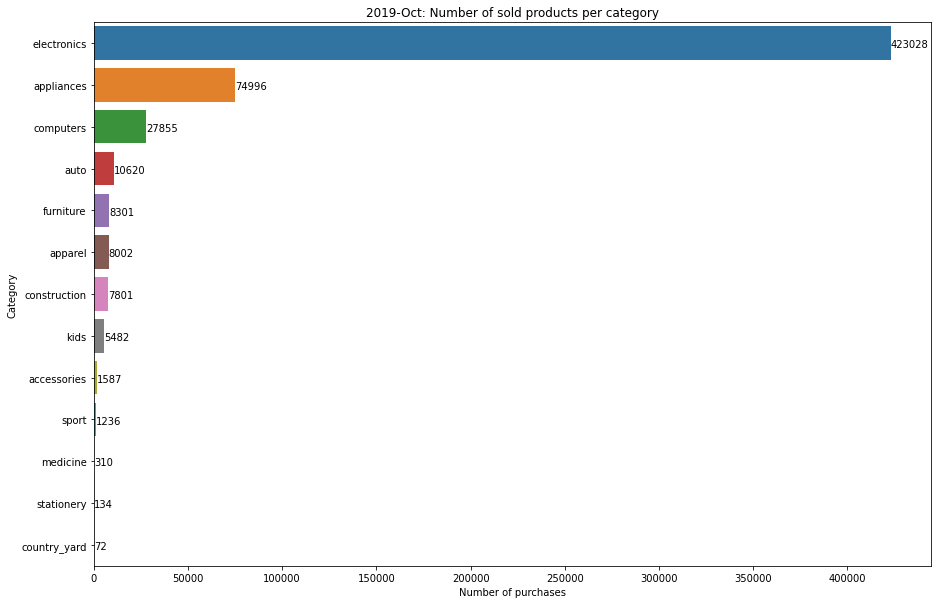

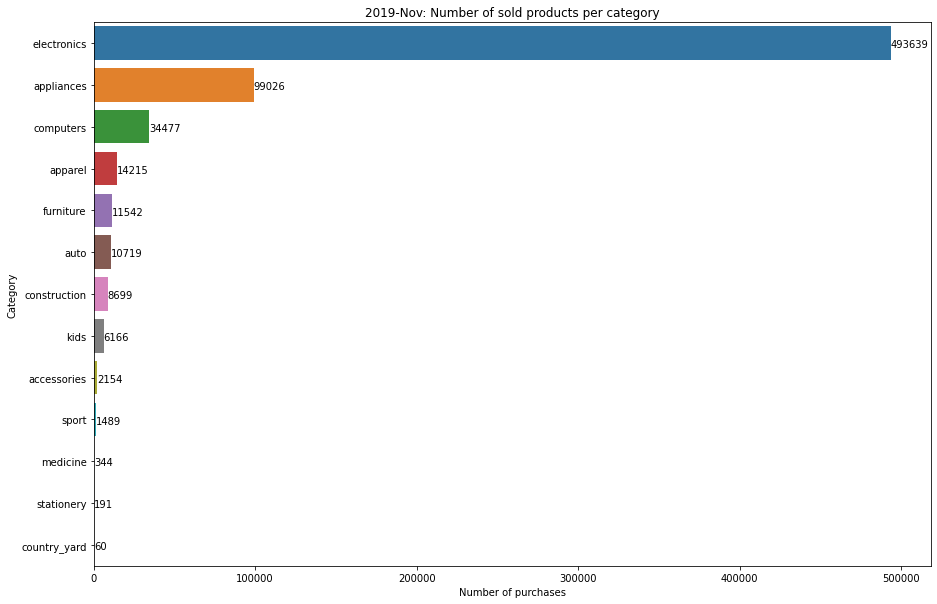

In [60]:
for df_label in df_labels:
    get_most_trending_products(df_label=df_label, nrows=None)  # take all rows

In [4]:
# plan B: use dash library to paralelize the computation
# plan C: do the parsing with bash script | generate_subset_with_n_purchases_per_category.sh
def get_most_trending_products_bash(df_label: str = default_file_label):
    # print(f"{df_label + ' | ' if df_label else ''}most trending products categories")
    # read output of the script with category - n_of_purchases columns
    most_trending_products_df = pd.read_csv(
        f"purchases/{df_label}.csv.purchases-per-category.csv"
    )
    # split categories from sub categories (leave only categories)
    most_trending_products_df.loc[:, 'category'] = \
        most_trending_products_df['category'].str.split('.').str[0]
    # sum up all sails in a category
    most_trending_categories_df = most_trending_products_df.groupby('category').sum()
    most_trending_categories_df.reset_index(inplace=True)
    # sort in descending order
    most_trending_categories_df.sort_values(by=['n_purchases'], ascending=False, inplace=True)
    # print(most_trending_categories_df)
    fig, ax = plt.subplots(figsize=(15, 10))
    bar_plt = sns.barplot(data=most_trending_categories_df, x="n_purchases", y="category", palette='tab10')
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of purchases', 
        title=f"{df_label + ': ' if df_label else ''}Number of sold products per category"
    )
    show_values_on_bars(ax, "h", 0.3)
    plt.show()

## Plot the most visited subcategories

We assume that each subcategory is composed by combination of the category and all the nested (sub) categories

The initial dataset is too big to be processed directly in pandas, we use a script '*generate_subset_with_n_views_per_category.sh*' which
 - makes a subset that contains only views (quite big as well)
 - finds all unique categories present in the subset
 - for each category calculates number of lines present in the subset
 
Category - is the first value before . separator, the rest are sub-categories

In [65]:
def get_most_visited_sub_categories(
    top_n: int = 10,
    df_label: str = default_file_label,
    aws: bool = default_aws,
    chunksize: int = deafult_chunksize, 
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        chunksize=chunksize,
        nrows=nrows,
        usecols=['category_code', 'event_type'],
        dtype={'category_code': str, 'event_type': str}
    )
    most_visited_sub_categories = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        events_operations = chunk[
            chunk['event_type'].isin(['view']) & ~(chunk['category_code'] == '')
        ].dropna().groupby(
            ['category_code']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_visits'}
        )
        if most_visited_sub_categories.empty:
            most_visited_sub_categories = events_operations
        else:
            most_visited_sub_categories = \
                most_visited_sub_categories.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_visited_sub_categories.reset_index(inplace=True)
    # sort in descending order
    most_visited_sub_categories.sort_values(by=['n_visits'], ascending=False, inplace=True)
    if top_n is not None and top_n > 0:
        most_visited_sub_categories = most_visited_sub_categories.iloc[:top_n, :]
    # plot results
    fig, ax = plt.subplots(figsize=(15, 10 if top_n is not None else 25))
    bar_plt = sns.barplot(data=most_visited_sub_categories, x="n_visits", y="category_code", palette='tab10')
    sns.set(rc={'figure.figsize': (15, 10 if top_n is not None else 25)})
    show_values_on_bars(ax, "h", 0.3)
    bar_plt.set(
        ylabel='Category', 
        xlabel='Number of visits', 
        title=f"{df_label + ': ' if df_label else ''}Number of visits per sub category"
        f"{'| top #' + str(top_n) + ' sub categories' if top_n is not None else ''}"
    )
    plt.show()

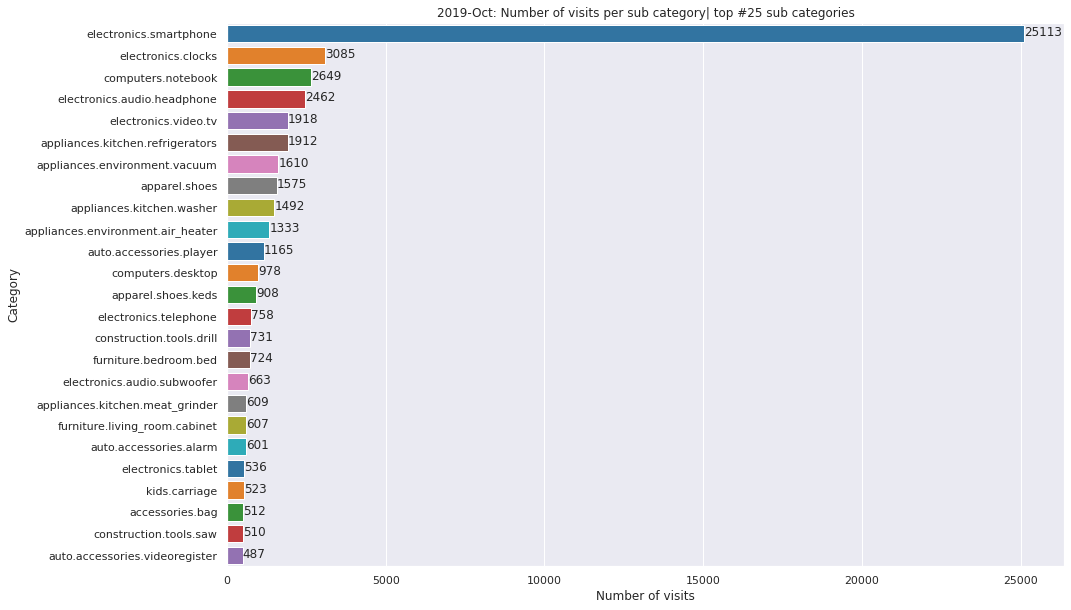

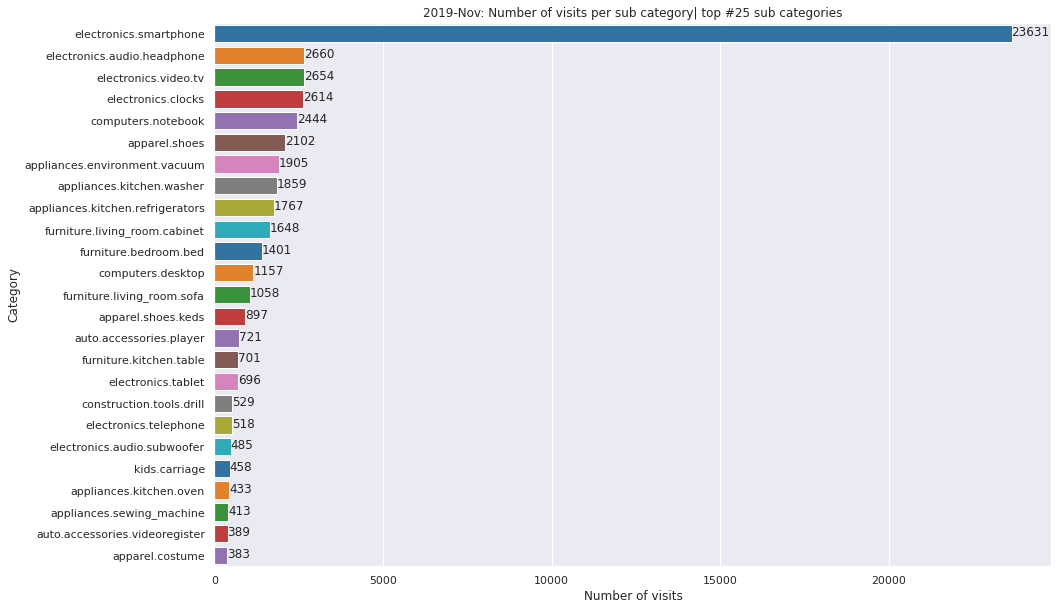

In [66]:
for df_label in df_labels:
    get_most_visited_sub_categories(df_label=df_label, top_n=25)

## What are the 10 most sold products per category?

Category - is the first value before . separator, the rest are sub-categories

In [76]:
# bash script is faster, can be used instead
def get_categories(
    df_label: str = default_file_label,
    aws: bool = default_aws,
    chunksize: int = deafult_chunksize, 
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        chunksize=chunksize,
        nrows=nrows,
        usecols=['category_code'],
        dtype={'category_code': str},
    )
    all_categories = pd.DataFrame()
    for chunk in reader:
        print('.', end = '')
        chunk = chunk.replace('', np.nan).dropna()
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        chunk.drop_duplicates(inplace=True)
        if all_categories.empty:
            all_categories = chunk
        else:
            all_categories = pd.concat([all_categories, chunk])
    all_categories = list(all_categories.category_code.unique())
    print('\n', end = '')
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"Categories: "
    )
    for category in all_categories:
        print(category)
    return all_categories

In [77]:
categories_dict = dict()
for df_label in df_labels:
    categories_dict[df_label] = get_categories(df_label=df_label, nrows=None, chunksize=1_000_000)

...........................................
2019-Oct | Categories: 
appliances
furniture
computers
electronics
apparel
construction
auto
kids
sport
accessories
medicine
stationery
country_yard
....................................................................
2019-Nov | Categories: 
electronics
appliances
computers
furniture
apparel
construction
auto
accessories
kids
sport
medicine
country_yard
stationery


In [78]:
def get_most_sold_products_per_category(
    category: str,
    top_n: int = 10,
    df_label: str = default_file_label,
    aws: bool = default_aws,
    chunksize: int = deafult_chunksize, 
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        chunksize=chunksize,
        nrows=nrows,
        usecols=['category_code', 'event_type', 'product_id'],
        dtype={'category_code': str, 'event_type': str, 'product_id': np.uint32}
    )
    most_sold_products = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        events_operations = chunk[
            chunk['event_type'].isin(['purchase']) 
            & (chunk['category_code'] == category)
        ].dropna().groupby(
            ['category_code', 'product_id']
        ).event_type.count().to_frame().rename(
            columns={'event_type': 'n_purchases'}
        )
        if most_sold_products.empty:
            most_sold_products = events_operations
        else:
            most_sold_products = \
                most_sold_products.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_sold_products.reset_index(inplace=True)
    most_sold_products = most_sold_products.sort_values(by='n_purchases', ascending=False).head(top_n)
    top_n_sold_products = list(most_sold_products.product_id.values)
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"The 10 most sold products per '{category}' are:"
    )
    print(top_n_sold_products)
    print(most_sold_products)
        
    return top_n_sold_products

In [79]:
for df_label in df_labels:
    for category in categories_dict.get(df_label, list())[:1]:
        get_most_sold_products_per_category(category=category, df_label=df_label, top_n=10)

2019-Oct | The 10 most sold products per 'appliances' are:
[3700926, 3600163, 3600661, 3700766, 2800403, 3601405, 2701657, 3600182, 3601489, 4600603]
    category_code  product_id  n_purchases
86     appliances     3700926            6
50     appliances     3600163            4
54     appliances     3600661            4
79     appliances     3700766            4
26     appliances     2800403            3
64     appliances     3601405            3
18     appliances     2701657            3
51     appliances     3600182            3
70     appliances     3601489            3
107    appliances     4600603            2
2019-Nov | The 10 most sold products per 'electronics' are:
[1004856, 1004767, 1005115, 1004249, 1004833, 1004870, 4804056, 1002544, 1004739, 1005105]
    category_code  product_id  n_purchases
66    electronics     1004856           64
51    electronics     1004767           40
101   electronics     1005115           39
28    electronics     1004249           27
60    elect

# RQ3

 - For each category, **what’s the brand whose prices are higher on average?**
 

 - Write a function that asks the user a category in input and returns a **plot indicating the average price of the products sold by the brand.**
 
 
 - **Find, for each category, the brand with the highest average price.** 
 
   Return all the results in ascending order by price.

## For each category, what’s the brand whose prices are higher on average?

In [ ]:
def brand_with_highest_prices_per_category(
    category: str,
    df_label: str = default_file_label,
    aws: bool = default_aws,
    chunksize: int = deafult_chunksize, 
    nrows: int = default_nrows
):
    reader = read_csv(
        df_label=df_label,
        aws=aws,
        chunksize=chunksize,
        nrows=nrows,
        usecols=['category_code', 'brand', 'price'],
        dtype={'category_code': str, 'brand': str, 'price': np.uint32}
    )
    most_sold_products = pd.DataFrame()
    i = 0
    for chunk in reader:
        # print(f"Processing a chunk #{i}")
        # take only the category
        chunk.loc[:, 'category_code'] = chunk.category_code.str.split('.').str[0]
        chunk.drop_duplicates(inplace=True)
        category_brands = chunk[
            chunk['category_code'] == category
        ].dropna().groupby(
            ['category_code', 'brand', 'price']
        ).event_type.count().to_frame().rename(
            columns={'price': 'avg_price'}
        )
        if most_sold_products.empty:
            most_sold_products = events_operations
        else:
            most_sold_products = \
                most_sold_products.add(events_operations, fill_value=0).astype(np.uint32)
        i += 1
    most_sold_products.reset_index(inplace=True)
    most_sold_products = most_sold_products.sort_values(by='n_purchases', ascending=False).head(top_n)
    top_n_sold_products = list(most_sold_products.product_id.values)
    print(
        f"{df_label + ' | ' if df_label else ''}"
        f"The 10 most sold products per '{category}' are:"
    )
    print(top_n_sold_products)
    print(most_sold_products)
        
    return top_n_sold_products

## Write a function that asks the user a category in input and returns a plot indicating the average price of the products sold by the brand.

In [ ]:
# TODO

## Find, for each category, the brand with the highest average price.

In [ ]:
# TODO

# RQ4

In [ ]:
# Add to the notebook

# RQ5

In [ ]:
# Add to the notebook

# RQ6

In [ ]:
# Add to the notebook

In [296]:
#coversion rate => (#purchase)/(#view)
#we can esealy use the subdataframe of RQ2

#sales is a sub that contain only purchased product
#sales = subRQ2[subRQ2['event_type']=='purchase']
product_sold = len(sales)


In [297]:
product_sold

682721

In [298]:
#while visited cointain only visited product
#visited = subRQ2[subRQ2['event_type']=='view']
product_watched = len(visited)

In [299]:
overall_conversion_rate = product_sold/product_watched
round(overall_conversion_rate,6)

0.015982

In [246]:
#RQ6.1 rate for each categories


In [300]:
# number of sales (calculated in RQ2)
number_of_sales
#we obtained a pandas series with the number of products sold

category_code
accessories       2154
apparel          14215
appliances       99026
auto             10719
computers        34477
construction      8699
country_yard        60
electronics     493639
furniture        11542
kids              6166
medicine           344
sport             1489
stationery         191
Name: product_id, dtype: int64

In [301]:
watched = subRQ2[subRQ2['event_type']=='view']

In [302]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics.smartphone
1,view,5000088,appliances.sewing_machine
3,view,3601530,appliances.kitchen.washer
4,view,1004775,electronics.smartphone
5,view,1306894,computers.notebook


In [ ]:
#s.str.split()

In [311]:
watched['category_code'].head()

0       electronics.smartphone
1    appliances.sewing_machine
3    appliances.kitchen.washer
4       electronics.smartphone
5           computers.notebook
Name: category_code, dtype: object

In [308]:
#watched['category_code'].str.split('.')

In [309]:
#watched['category_code']= watched['category_code'].str.split()[0]

In [312]:
watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]

<ipython-input-312-d69c0d1f5796>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  watched['category_code'] = [el.split('.')[0] for el in list(watched['category_code']) if type(el) == str]


In [313]:
watched.head()

,event_type,product_id,category_code
0,view,1003461,electronics
1,view,5000088,appliances
3,view,3601530,appliances
4,view,1004775,electronics
5,view,1306894,computers


In [314]:
times_watched = watched.groupby('category_code').product_id.count()

In [381]:
times_watched
#we obtained a pandas series with the number o product view for aech category 

category_code
accessories       380373
apparel          2942622
appliances       8037980
auto             1164278
computers        4029049
construction     1047072
country_yard       17299
electronics     21988192
furniture        2058798
kids              779517
medicine           20764
sport             240763
stationery         11943
Name: product_id, dtype: int64

In [376]:
times_watched.head()

category_code
accessories     380373
apparel        2942622
appliances     8037980
auto           1164278
computers      4029049
Name: product_id, dtype: int64

In [318]:
number_of_sales.head()

category_code
accessories     2154
apparel        14215
appliances     99026
auto           10719
computers      34477
Name: product_id, dtype: int64

In [317]:
type(number_of_sales) == type(times_watched) 
#both elements are pandas series so we can just deviding them by using devide() command

True

In [383]:
#purchase rate of each category
purchase_rate = number_of_sales.divide(times_watched)
purchase_rate

category_code
accessories     0.005663
apparel         0.004831
appliances      0.012320
auto            0.009207
computers       0.008557
construction    0.008308
country_yard    0.003468
electronics     0.022450
furniture       0.005606
kids            0.007910
medicine        0.016567
sport           0.006185
stationery      0.015993
Name: product_id, dtype: float64

In [ ]:
#TODO recheck purchase rate vs conversion rate
#TODO plot 

# RQ7